#### 使用线性的inverse method中的MNE/dSPM/sLORETA/eLORETA进行溯源定位

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator,apply_inverse

In [4]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw,stim_channel='STI 014')
event_id = dict(aud_l=1) # event trigger and conditions
tmin = -.2 # start of each epoch (200ms before the trigger)
tmax = .5 # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443','EEG 053']
picks = mne.pick_types(raw.info,meg=True,eeg=False,eog=True,exclude='bads')

Opening raw data file /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
319 events found
Event IDs: [ 1  2  3  4  5 32]


In [8]:
baseline = (None,0)
reject = dict(grad=4000e-13,mag=4e-12,eog=150e-6)
epochs = mne.Epochs(raw,events,event_id,tmin,tmax,proj=True,picks=picks,baseline=baseline,reject=reject)

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
4 projection items activated


In [9]:
epochs

<Epochs  |   72 events (good & bad), -0.199795 - 0.499488 sec, baseline [None, 0], ~3.6 MB, data not loaded,
 'aud_l': 72>

#### Compute regularized noise covariance

Loading data for 55 events and 106 original time points ...
    Created an SSP operator (subspace dimension = 3)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
Reducing data rank from 305 -> 302
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 1705
log-likelihood on unseen data (descending order):
   shrunk: -1466.524
   empirical: -1574.608
selecting best estimator: shrunk
[done]


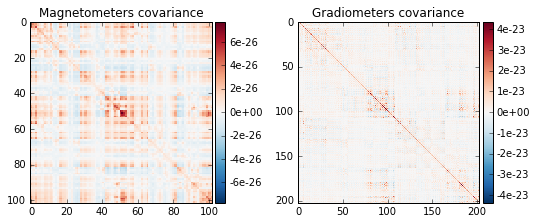

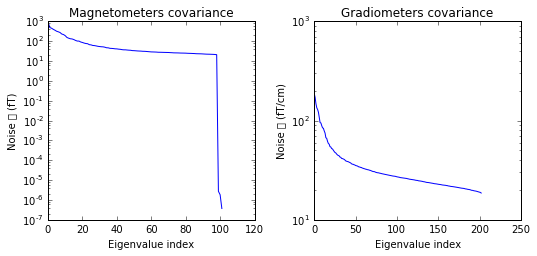

In [11]:
noise_cov = mne.compute_covariance(epochs,tmax=0,method=['shrunk','empirical'],rank=None,verbose=True)
fig_cov,fig_spectra = mne.viz.plot_cov(noise_cov,raw.info);

#### Compute the evoked response

In [18]:
evoked = epochs.average().pick_types(meg=True)
evoked

<Evoked  |  'aud_l' (mean, N=55), [-0.1998, 0.49949] sec, 305 ch, ~3.8 MB>

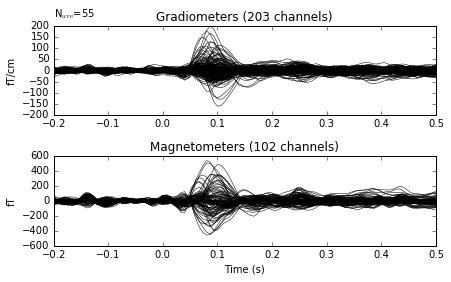

In [19]:
evoked.plot(time_unit='s');

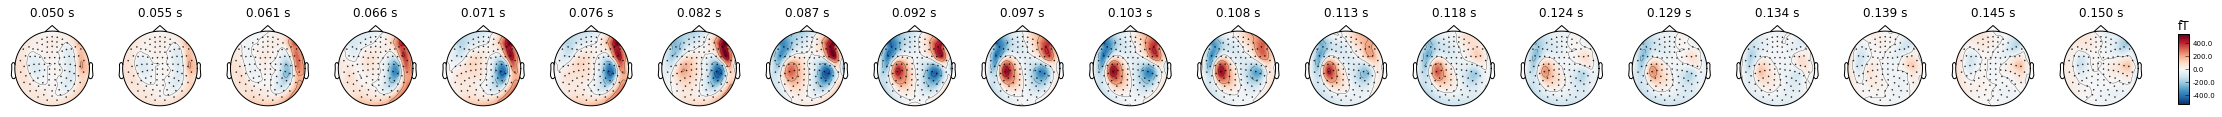

In [26]:
evoked.plot_topomap(times=np.linspace(0.05,0.15,20),ch_type='mag',time_unit='s');

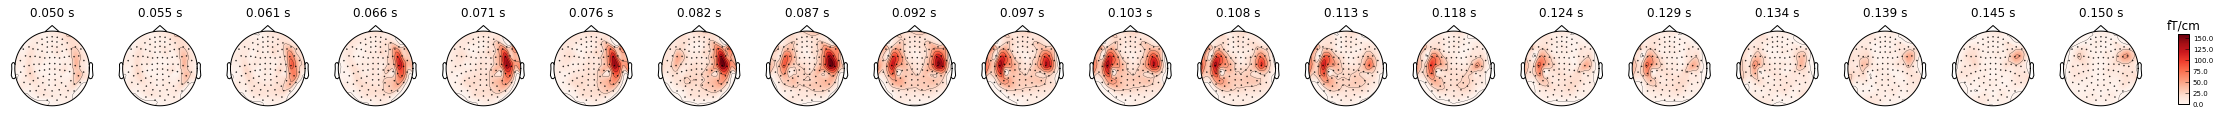

In [27]:
evoked.plot_topomap(times=np.linspace(0.05,0.15,20),ch_type='grad',time_unit='s');

8 projection items activated
estimated rank (grad): 203
Created an SSP operator (subspace dimension = 3)
8 projection items activated
estimated rank (mag): 99
    Created an SSP operator (subspace dimension = 3)
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)


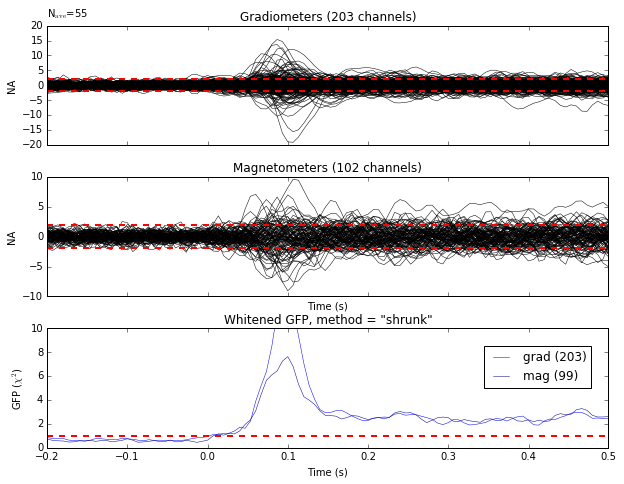

In [29]:
## show whitening
evoked.plot_white(noise_cov,time_unit='s');

#### Inverse modeling: MNE/dSPM on evoked and raw data

In [32]:
# Read the forward solution and compute the inverse operator
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from /home/reallocing/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [36]:
# make an MEG inverse operator
info = evoked.info
info

<Info | 19 non-empty fields
    bads : list | 0 items
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 305 items (GRAD: 203, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 146 items
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 305
    proc_history : list | 0 items
    projs : list | PCA-v1: on, PCA-v2: on, PCA-v3: on, ...
    sfreq : float | 150.153747559 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj

In [37]:
inverse_operator = make_inverse_operator(info,fwd,noise_cov,loose=0.2,depth=0.8)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 305 channels.
    Created an SSP operator (subspace dimension = 3)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Creating the depth weighting matrix...
    203 planar channels
    limit = 7265/7498 = 10.037795
    scale = 2.52065e-08 exp = 0.8
Computing inverse operator with 305 channels.
Creating the source covariance matrix
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.69159
    scaling factor to adjust the trace = 8.8188e+18


In [40]:
inverse_operator

<InverseOperator | MEG channels: 306 | EEG channels: 0 | Source space: surface with 7498 sources | Source orientation: Free>

#### You can write it to disk with::
```
     >>> from mne.minimum_norm import write_inverse_operator
     >>> write_inverse_operator('sample_audvis-meg-oct-6-inv.fif',
                               inverse_operator)
```

#### Compute inverse solution

In [41]:
method = 'dSPM'
snr = 3.
lambda2 = 1. / snr ** 2
stc,residual = apply_inverse(evoked,inverse_operator,lambda2,method=method,pick_ori=None,return_residual=True,verbose=True) #https://martinos.org/mne/stable/generated/mne.minimum_norm.apply_inverse.html#mne.minimum_norm.apply_inverse
# stc: The source estimates.

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "aud_l"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.0% variance
    Combining the current components...
    dSPM...
[done]


In [43]:
print(stc,residual)

(<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.795213158 (ms), tmax : 499.488032896 (ms), tstep : 6.65984043861 (ms), data shape : (7498, 106)>, <Evoked  |  'aud_l' (mean, N=55), [-0.1998, 0.49949] sec, 305 ch, ~3.8 MB>)


#### Visualization

In [48]:
stc.to_data_frame()

Converting time column to int64...


signal          LH 841   LH 1170   LH 1329   LH 1609   LH 2067   LH 2103  \
subject time                                                               
sample  -200  0.256938  0.445522  0.147303  0.114731  0.695068  0.422276   
        -193  1.214314  0.449365  1.133963  0.398167  0.394059  0.417182   
        -186  0.707822  0.118921  1.210367  0.297563  0.192513  0.472843   
        -180  0.823660  0.651395  0.465776  0.357207  0.642381  0.318417   
        -173  1.214039  0.359983  0.126572  0.346427  0.455627  0.221751   
        -166  0.589519  0.699507  0.349077  0.205850  0.635720  0.241965   
        -160  0.157878  1.321471  0.491743  0.716757  0.655908  1.079838   
        -153  0.347762  0.999722  0.253811  1.392791  1.025816  1.428417   
        -147  0.751342  0.223001  0.456606  0.811108  1.029939  0.571909   
        -140  0.876030  0.554773  0.690114  0.568829  0.214495  0.552245   
        -133  0.017100  0.847681  0.231327  1.124566  1.108916  0.858098   
        -127  1.599803  0.678802  0.473000  0.614875  1.008629  0.680856   
        -120  2.005208  0.387684  0.323168  0.227640  0.474786  0.706396   
        -113  0.345454  0.326386  0.371000  0.363306  0.356513  0.364702   
        -107  1.404345  1.232853  1.106061  1.127626  0.715315  1.113741   
        -100  0.909412  1.806980  1.106466  1.761245  0.757200  1.878326   
        -93   0.676605  0.818237  0.152552  0.634814  0.354953  0.791672   
        -87   0.978294  1.118765  0.967776  1.432677  0.522781  1.039877   
        -80   0.236747  1.798371  1.383757  1.994860  0.744046  1.589403   
        -73   0.313556  0.731898  1.393908  0.865292  0.225316  0.935837   
        -67   0.474213  0.303781  1.035648  0.325605  0.465049  0.589161   
        -60   0.697107  0.278714  0.150487  0.462242  0.504728  0.307137   
        -53   0.773054  0.497269  0.772205  0.832444  0.527093  0.718167   
        -47   0.333216  1.168347  1.059297  1.041994  0.263900  1.423656   
        -40   0.790059  0.710484  0.724983  0.225334  0.597287  0.739438   
        -33   1.105002  0.890387  0.146576  0.647791  0.880133  0.592481   
        -27   0.270990  1.342195  0.345332  0.422467  0.678465  0.719570   
        -20   0.835976  0.305188  0.261483  0.556424  0.850592  0.221855   
        -13   0.202960  0.251154  0.642330  0.312499  0.490602  0.423464   
        -7    0.871117  0.588445  1.283730  0.399584  0.226447  0.396578   
...                ...       ...       ...       ...       ...       ...   
         306  1.519218  0.736823  0.978498  0.487948  1.280323  0.276649   
         313  0.656971  1.017768  0.577418  0.615889  0.741587  0.845551   
         320  1.464793  2.234381  0.882289  2.492207  1.254827  1.940429   
         326  2.576420  1.520618  0.461416  3.118358  1.579613  1.958941   
         333  2.408420  0.283257  1.005788  2.261009  0.747033  1.416667   
         340  1.529493  0.390813  1.408239  2.170617  0.780476  1.739518   
         346  1.354345  1.376809  1.768254  3.653081  0.933165  2.854797   
         353  1.498348  1.971387  1.532805  4.461269  0.944246  3.449238   
         360  1.119422  1.506541  0.348620  2.624776  0.992170  2.493963   
         366  0.400830  0.461606  0.610228  0.499857  1.980186  0.798031   
         373  0.425173  0.706278  0.248650  1.335512  1.288047  0.426604   
         380  1.123995  0.628949  0.780836  0.539417  1.342963  0.348032   
         386  1.342340  0.310313  1.106598  1.313726  1.388273  0.981704   
         393  0.850370  0.292168  0.933391  1.541590  1.103152  0.671617   
         400  0.607601  0.737103  0.964178  1.425593  1.220384  0.134935   
         406  0.815909  0.411601  1.059091  1.542849  1.033372  0.322556   
         413  0.928355  0.917738  0.907494  1.681978  0.623814  1.267612   
         420  0.552633  1.311469  0.596164  1.669377  1.149130  1.677942   
         426  0.398956  0.748581  0.130769  1.668272  1.234930  1.316880   
         433  0.364665  0.606904  0.836059  1.63

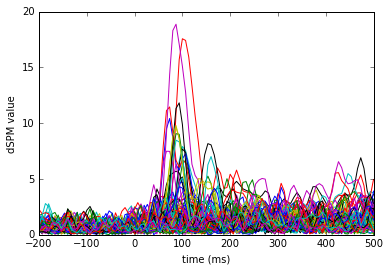

In [44]:
plt.figure()
plt.plot(1e3 * stc.times,stc.data[::100,:].T)
plt.xlabel('time (ms)')
plt.ylabel('%s value'%method)
plt.show();

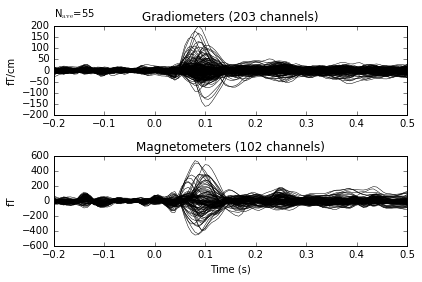

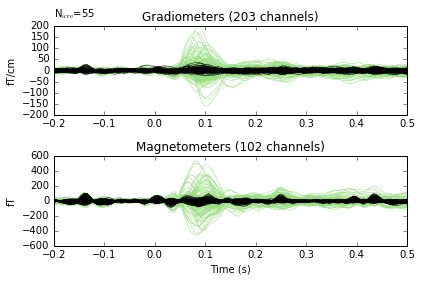

In [51]:
fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    ax.texts = []
    for line in ax.lines:
        line.set_color('#98df81')
residual.plot(axes=axes)

In [75]:
vertno_max, time_max = stc.get_peak(hemi='rh')
import os
os.environ['ETS_TOOLKIT'] = 'Qt5'
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'Qt5'
subjects_dir = data_path + '/subjects'
# 需要提前安装mayavi 
# https://github.com/enthought/mayavi
# views must be one of ['lat', 'med', 'ros', 'cau', 'dor' 'ven', 'fro', 'par']
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[8, 12, 15]), views='lat',  
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=5)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
               scale_factor=0.6, alpha=0.5)
brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
               font_size=14)

ValueError: cannot set toolkit to Qt5 because it has already been set to pyqt

### Morph data to average brain

In [61]:
# setup source morph
morph = mne.compute_source_morph(
    src=inverse_operator['src'], subject_from=stc.subject,
    subject_to='fsaverage', spacing=5,  # to ico-5
    subjects_dir=subjects_dir)
# morph data
stc_fsaverage = morph.apply(stc)

brain = stc_fsaverage.plot(**surfer_kwargs)
brain.add_text(0.1, 0.9, 'Morphed to fsaverage', 'title', font_size=20)
del stc_fsaverage

surface source space inferred...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    17 smooth iterations done.
    14 smooth iterations done.
[done]
[done]


RuntimeError: No traitsui.toolkits plugin found for toolkit null

### Dipole orientations

In [60]:
stc_vec = apply_inverse(evoked, inverse_operator, lambda2,
                        method=method, pick_ori='vector')
brain = stc_vec.plot(**surfer_kwargs)
brain.add_text(0.1, 0.9, 'Vector solution', 'title', font_size=20)
del stc_vec

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "aud_l"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.0% variance
    dSPM...
[done]


ImportError: No module named surfer

In [71]:
for mi, (method, lims) in enumerate((('dSPM', [8, 12, 15]),
                                     ('sLORETA', [3, 5, 7]),
                                     ('eLORETA', [0.75, 1.25, 1.75]),)):
    surfer_kwargs['clim']['lims'] = lims
    stc = apply_inverse(evoked, inverse_operator, lambda2,
                        method=method, pick_ori=None)
    brain = stc.plot(figure=mi, **surfer_kwargs)
    brain.add_text(0.1, 0.9, method, 'title', font_size=20)
    del stc

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "aud_l"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.0% variance
    Combining the current components...
    dSPM...
[done]


RuntimeError: No traitsui.toolkits plugin found for toolkit pyqt